In [27]:
# to do
# fisher score, chi square test graphs
# memory reduction for ddl case id and others

In [2]:
# Import libraries
import glob
import pandas as pd
import dask.dataframe as dd

cases = pd.concat([pd.read_csv(f) for f in glob.glob('./csv/cases/*.csv') if int(f[18:22]) > 2015], ignore_index = True)

In [3]:
cases.head()

,ddl_case_id,year,state_code,dist_code,court_no,cino,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name,date_of_filing,date_of_decision,date_first_list,date_last_list,date_next_list
0,01-01-01-201900000012016,2016,1,1,1,MHNB030000032016,chief judicial magistrate,0 male,0 male,-9999,0,1940.0,767.0,26,2016-01-02,2016-02-16,2016-01-02,2016-02-16,2016-02-16
1,01-01-01-201900000022016,2016,1,1,1,MHNB030000042016,chief judicial magistrate,0 male,0 male,-9999,0,1940.0,767.0,26,2016-01-02,2016-02-16,2016-01-02,2016-02-16,2016-02-16
2,01-01-01-201900000032016,2016,1,1,1,MHNB030000052016,chief judicial magistrate,0 male,1 female,-9999,0,1940.0,4878.0,43,2016-01-02,2016-02-13,2016-01-02,2016-02-13,2016-02-13
3,01-01-01-201900000042016,2016,1,1,1,MHNB030000062016,chief judicial magistrate,0 male,0 male,-9999,1,1940.0,7430.0,23,2016-01-05,2017-06-07,2016-01-05,2017-06-07,2017-06-07
4,01-01-01-201900000052016,2016,1,1,1,MHNB030000072016,chief judicial magistrate,0 male,0 male,-9999,0,1940.0,5251.0,26,2016-01-06,2016-02-18,2016-01-06,2016-02-18,2016-02-18


In [4]:
cases_pre = cases    

cases_pre = cases_pre.drop(['date_first_list', 'date_last_list', 'date_next_list', 'cino', 'date_of_filing', 'date_of_decision'], axis=1)
cases_pre = cases_pre.drop_duplicates()

In [5]:
print(cases_pre.shape)

(38139072, 13)


In [6]:
cases_pre['female_defendant'] = cases_pre['female_defendant'].str.replace('[a-zA-Z]', '').astype('int')
cases_pre['female_petitioner'] = cases_pre['female_petitioner'].str.replace('[a-zA-Z]', '').astype('int')

/tmp/ipykernel_8909/4274106871.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cases_pre['female_defendant'] = cases_pre['female_defendant'].str.replace('[a-zA-Z]', '').astype('int')
/tmp/ipykernel_8909/4274106871.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  cases_pre['female_petitioner'] = cases_pre['female_petitioner'].str.replace('[a-zA-Z]', '').astype('int')


In [7]:
cases_pre = cases_pre.loc[(cases_pre['female_adv_def'] != -9999) & (cases_pre['female_adv_def'] != -9998)]
cases_pre = cases_pre.loc[(cases_pre['female_adv_pet'] != -9999) & (cases_pre['female_adv_pet'] != -9998)]
cases_pre = cases_pre.loc[(cases_pre['female_defendant'] != -9999) & (cases_pre['female_defendant'] != -9998)]
cases_pre = cases_pre.loc[(cases_pre['female_petitioner'] != -9999) & (cases_pre['female_petitioner'] != -9998)]


In [8]:
cases_pre.dtypes

ddl_case_id           object
year                   int64
state_code             int64
dist_code              int64
court_no               int64
judge_position        object
female_defendant       int64
female_petitioner      int64
female_adv_def         int64
female_adv_pet         int64
type_name            float64
purpose_name         float64
disp_name              int64
dtype: object

In [9]:
cases_pre.memory_usage(deep=True)

Index                 5129696
ddl_case_id          51938172
year                  5129696
state_code            5129696
dist_code             5129696
court_no              5129696
judge_position       51036336
female_defendant      5129696
female_petitioner     5129696
female_adv_def        5129696
female_adv_pet        5129696
type_name             5129696
purpose_name          5129696
disp_name             5129696
dtype: int64

In [10]:
cases_pre['judge_position'] = cases_pre['judge_position'].astype('category')

cases_pre[['year', 'state_code', 'dist_code', 'court_no', 'disp_name', 'female_defendant', 'female_petitioner', 'female_adv_def', 'female_adv_pet']] = cases_pre[['year', 'state_code', 'dist_code', 'court_no', 'disp_name', 'female_defendant', 'female_petitioner', 'female_adv_def', 'female_adv_pet']].apply(pd.to_numeric, downcast='unsigned')
cases_pre[['type_name', 'purpose_name']] = cases_pre[['type_name', 'purpose_name']].apply(pd.to_numeric, downcast='float')


In [11]:
cases_pre.shape
cases_pre.head()

,ddl_case_id,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name
5,01-01-01-201900000062016,2016,1,1,1,chief judicial magistrate,0,1,1,0,1940.0,2813.0,16
11,01-01-01-201900000122016,2016,1,1,1,chief judicial magistrate,0,1,0,0,1940.0,5426.0,23
12,01-01-01-201900000132016,2016,1,1,1,chief judicial magistrate,0,1,0,1,1940.0,2813.0,27
18,01-01-01-201900000192016,2016,1,1,1,chief judicial magistrate,0,1,0,0,1940.0,767.0,33
37,01-01-01-201900000382016,2016,1,1,1,chief judicial magistrate,0,0,0,0,1940.0,2813.0,46


In [12]:
cases_pre.memory_usage(deep=True)

Index                 5129696
ddl_case_id          51938172
year                  1282424
state_code             641212
dist_code              641212
court_no               641212
judge_position        1322673
female_defendant       641212
female_petitioner      641212
female_adv_def         641212
female_adv_pet         641212
type_name             2564848
purpose_name          2564848
disp_name              641212
dtype: int64

In [13]:
# ordinal encoding of judge_position
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
cases_pre['judge_position'] = encoder.fit_transform(cases_pre[['judge_position']])
cases_pre['judge_position'] = cases_pre['judge_position'].astype('uint8')

In [14]:
cases_pre.head()

,ddl_case_id,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name
5,01-01-01-201900000062016,2016,1,1,1,102,0,1,1,0,1940.0,2813.0,16
11,01-01-01-201900000122016,2016,1,1,1,102,0,1,0,0,1940.0,5426.0,23
12,01-01-01-201900000132016,2016,1,1,1,102,0,1,0,1,1940.0,2813.0,27
18,01-01-01-201900000192016,2016,1,1,1,102,0,1,0,0,1940.0,767.0,33
37,01-01-01-201900000382016,2016,1,1,1,102,0,0,0,0,1940.0,2813.0,46


In [15]:
cases_pre.memory_usage(deep=True)

Index                 5129696
ddl_case_id          51938172
year                  1282424
state_code             641212
dist_code              641212
court_no               641212
judge_position         641212
female_defendant       641212
female_petitioner      641212
female_adv_def         641212
female_adv_pet         641212
type_name             2564848
purpose_name          2564848
disp_name              641212
dtype: int64

/tmp/ipykernel_8909/2579875749.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = cases_pre.corr()


<AxesSubplot: >

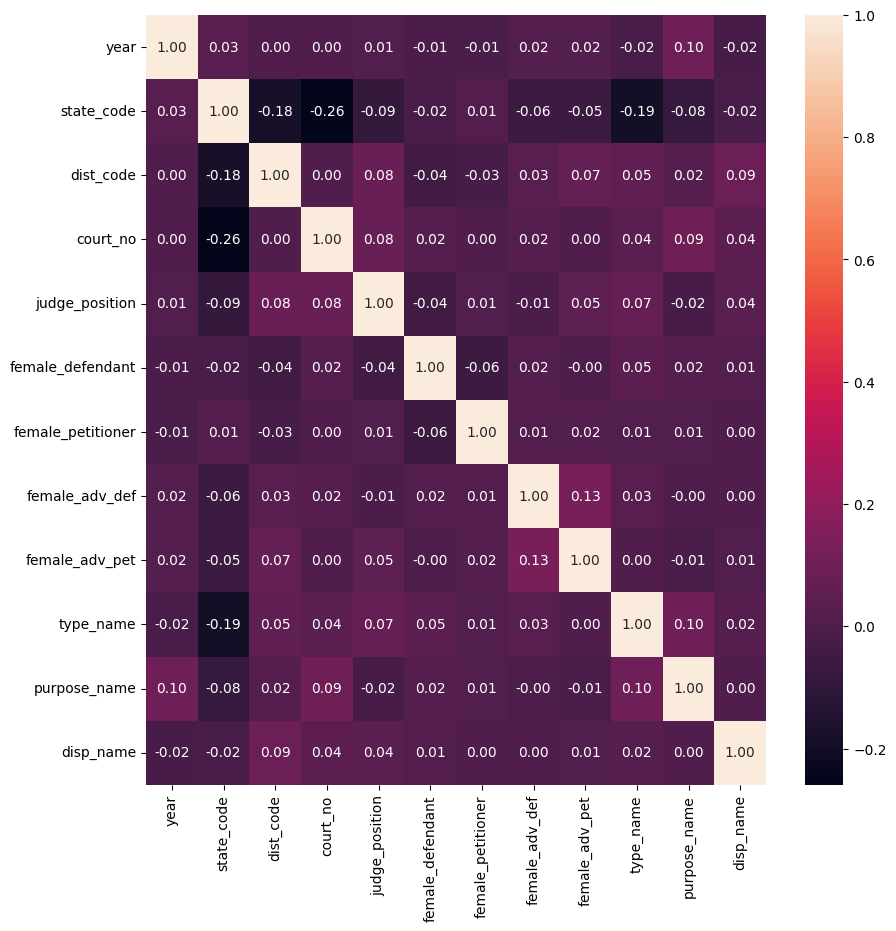

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
 
# correlation matrix
corr = cases_pre.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.2f')

In [17]:
cases_pre = cases_pre.fillna(cases_pre.mode())

In [18]:
cases_pre.head()

,ddl_case_id,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name
5,01-01-01-201900000062016,2016,1,1,1,102,0,1,1,0,1940.0,2813.0,16
11,01-01-01-201900000122016,2016,1,1,1,102,0,1,0,0,1940.0,5426.0,23
12,01-01-01-201900000132016,2016,1,1,1,102,0,1,0,1,1940.0,2813.0,27
18,01-01-01-201900000192016,2016,1,1,1,102,0,1,0,0,1940.0,767.0,33
37,01-01-01-201900000382016,2016,1,1,1,102,0,0,0,0,1940.0,2813.0,46


In [22]:
print(cases_pre['type_name'].nunique())
print(cases_pre['purpose_name'].nunique())
print(cases_pre['disp_name'].nunique())

print(cases_pre.shape)

4582
4119
50
(641212, 13)


In [24]:
# remove all non finite values
import numpy as np

cases_pre = cases_pre.replace([np.inf, -np.inf], np.nan)
cases_pre = cases_pre.dropna()

In [25]:
# ordinal encoding of type_name, purpose_name, disp_name
cases_pre[['type_name', 'purpose_name', 'disp_name']] = encoder.fit_transform(cases_pre[['type_name', 'purpose_name', 'disp_name']])
cases_pre[['type_name', 'purpose_name', 'disp_name']] = cases_pre[['type_name', 'purpose_name', 'disp_name']].astype('uint8')

In [26]:
cases_pre.memory_usage(deep=True)

Index                 5100096
ddl_case_id          51638472
year                  1275024
state_code             637512
dist_code              637512
court_no               637512
judge_position         637512
female_defendant       637512
female_petitioner      637512
female_adv_def         637512
female_adv_pet         637512
type_name              637512
purpose_name           637512
disp_name              637512
dtype: int64

In [29]:
# drop ddl case id
cases_pre = cases_pre.drop(['ddl_case_id'], axis=1)

In [31]:
# check what is good predictor for disp_name

# chi square test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = cases_pre.iloc[:, 0:9]  #independent columns
y = cases_pre.iloc[:, -1]    #target column i.e disp_name

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(5,'Score'))  #print 10 best features

# fisher score
from sklearn.feature_selection import f_classif

X = cases_pre.iloc[:, 0:9]  #independent columns
y = cases_pre.iloc[:, -1]    #target column i.e disp_name

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(5,'Score'))  #print 10 best features


            Specs          Score
2       dist_code  302686.898814
4  judge_position  242842.137989
1      state_code  189893.214780
3        court_no  166671.435390
8  female_adv_pet    3035.470526
              Specs       Score
2         dist_code  745.897278
1        state_code  655.360779
3          court_no  434.637421
4    judge_position  227.063156
5  female_defendant   74.259148


In [30]:
# logistic regression with disp_name as target

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = cases_pre.drop(['disp_name'], axis=1)
y = cases_pre['disp_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

/home/swetha/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of logistic regression classifier on test set: 0.52
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00       156
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00      1747
           4       0.00      0.00      0.00     11852
           5       0.00      0.00      0.00        22
           6       0.00      0.00      0.00       804
           7       0.00      0.00      0.00        33
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00       269
          12       0.00      0.00      0.00       115
          13       0.00      0.00      0.00       172
        

/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# get dataframe from purpose_name_key file

purpose_name_key = pd.read_csv('./csv/keys/purpose_name_key.csv')
disp_name_key = pd.read_csv('./csv/keys/disp_name_key.csv')
type_name_key = pd.read_csv('./csv/keys/type_name_key.csv')

# merge cases with purpose_name_key

merged = pd.merge(cases_pre, purpose_name_key, on='purpose_name', how='left')
merged.head()

,ddl_case_id,year_x,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name,year_y,purpose_name_s,count
0,01-01-01-201900000062016,2016,1,1,1,102,0,1,1,0,1940.0,2813.0,16,2010,for statement,30
1,01-01-01-201900000062016,2016,1,1,1,102,0,1,1,0,1940.0,2813.0,16,2011,filing of surety. (10am to 1pm ...,5
2,01-01-01-201900000062016,2016,1,1,1,102,0,1,1,0,1940.0,2813.0,16,2012,experte evicence,1
3,01-01-01-201900000062016,2016,1,1,1,102,0,1,1,0,1940.0,2813.0,16,2013,f. o. (11:00 am ...,1
4,01-01-01-201900000062016,2016,1,1,1,102,0,1,1,0,1940.0,2813.0,16,2014,eviddence of plaintiff / petitioner,5841


In [18]:
merged = merged.drop(['year_y', 'count', 'purpose_name'], axis=1)

In [19]:
merged = pd.merge(merged, disp_name_key, on='disp_name', how='left')
merged = merged.drop(['year', 'count'], axis=1)

merged = pd.merge(merged, type_name_key, on='type_name', how='left')
merged = merged.drop(['year', 'count', 'type_name'], axis=1)

KeyboardInterrupt: 

In [ ]:
merged['purpose_name_s'] = merged['purpose_name_s'].str.split(' ').str[0]

In [ ]:
merged.head()

,ddl_case_id,year_x,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,disp_name,purpose_name_s
0,01-01-01-201900000062016,2016,1,1,1,102,0,1,1,0,1940.0,16,for
1,01-01-01-201900000062016,2016,1,1,1,102,0,1,1,0,1940.0,16,filing
2,01-01-01-201900000062016,2016,1,1,1,102,0,1,1,0,1940.0,16,experte
3,01-01-01-201900000062016,2016,1,1,1,102,0,1,1,0,1940.0,16,f.
4,01-01-01-201900000062016,2016,1,1,1,102,0,1,1,0,1940.0,16,eviddence


In [ ]:
# merge with type_name_key file